# Simple Model: GTEx by Tissue

Split GTEx up by tissue and use that as the background dataset for the simple model

# Inputs

In [22]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import time
from collections import OrderedDict

sns.set_style('whitegrid')

In [5]:
df = pd.read_hdf('/mnt/data/Objects/tcga_gtex_tpm_norm_filt.hd5')
df.head(2)

,id,tissue,subtype,tumor,label,RP11-40C6.2,IGHG1,IGKC,KRT5,IGLC2,...,IGHEP1,RP11-44N21.4,GAPDHP61,P2RX5-TAX1BP3,RP11-408H20.3,RP13-726E6.2,CTB-43E15.1,ZNF878,OR2H2,RP4-530I15.9
GTEX-UTHO-1226-SM-3GAEE,GTEX-UTHO-1226-SM-3GAEE,Heart,Heart_Atrial_Appendage,no,gtex,0.000000,10.302941,10.712460,2.750618,7.780669,...,0.000000,0.0,0.0,0.150556,0.0,0.000000,0.0,0.070387,0.790754,0.815589
GTEX-146FH-1726-SM-5QGQ2,GTEX-146FH-1726-SM-5QGQ2,Esophagus,Esophagus_Mucosa,no,gtex,2.970847,8.778885,10.445933,12.393268,8.440056,...,0.176318,0.0,0.0,0.411426,0.0,0.176318,0.0,0.622930,0.042644,0.378503


Center data for speedup

In [6]:
genes = df.columns[5:]
df[genes] = df[genes].apply(lambda x: (x - x.mean()) / x.std())

Read in drug genes

In [7]:
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]
len(drug_genes)

85

Subset by dataset

In [8]:
cols = df.columns[:5].tolist()
drug_df = df[cols + drug_genes]

gtex = df[df.label == 'gtex']
normal = df[df.label == 'tcga-normal']
tumor = df[df.label == 'tcga-tumor']

In [9]:
def plot_gene_dist(n_of_1, gene):
    plt.axvline(n_of_1[gene], label='n-of-1', color='red')
    sns.kdeplot(gtex[gene], label='gtex')
    sns.kdeplot(normal[gene], label='normal')
    sns.kdeplot(tumor[gene], label='tumor')    
    plt.title(gene);

In [10]:
def fit_genes(genes, datasets):
    fits = {}
    for gene in genes:
        for name, dataset in datasets.items():
            key = f'{gene}-{name}'
            fits[key] = st.norm.fit(dataset[gene])
    return fits

In [11]:
def train_linear(n_of_1, genes, datasets, fits, n_samples=200, tune=1000):
    """
    n_of_1: tumor sample 
    genes: genes to learn
    datasets: datasets to include
    fits = fits[gene-dataset] contain MAP of expression
    n_samples = Samples to learn
    """
    with pm.Model() as model:
        # Priors for linear model
        alpha = pm.Normal('alpha', 0, 5)
        beta = pm.Normal('beta', 0, 5, shape=len(datasets))
        
        # Convert fits into Normal RVs
        exp_rvs = {key: pm.Normal(key, *fits[key]) for key in fits}
        
        # Define linear model for each gene
        mu = {}
        for i, gene in enumerate(genes):
            mu[gene] = alpha
            for j, (name, _) in enumerate(datasets.items()):
                mu[gene] += exp_rvs[f'{gene}-{name}'] * beta[j]
        
        # Single sigma across all genes
        sigma = pm.InverseGamma('sigma', 1)
        
        # Define z distributions for each mu
        z = {}
        for i, gene in enumerate(genes):
            obs = n_of_1[gene]
            z[gene] = pm.Laplace(gene, mu=mu[gene], b=sigma, observed=obs)
        
        # Calculate trace
        trace = pm.sample(n_samples, 
                          tune=tune, 
                          nuts_kwargs={'target_accept': 0.90},
                          njobs=12)
    return model, trace

In [12]:
tumor_id = 'TCGA-KK-A7B2-01'
n_of_1 = tumor.loc[tumor_id]

def posterior_from_linear(trace, gene, n_of_1=n_of_1, gtex=gtex, ax=None):
    # Get Median of priors
    z = trace['alpha']
    N = len(z)
    
    # 1000 samples from our datasets
    tissues = sorted(gtex.tissue.unique())
    for i, t in enumerate(tissues):
        samples = np.random.choice(gtex[gtex.tissue == t][gene], N)
        z += trace['beta'][:,i] * samples
    
    #gtex_samples = np.random.choice(gtex[gene], N)
    #normal_samples = np.random.choice(normal[gene], N)
    
    # Calculate z based on samples
    #z = a + b1 * gtex_samples + b2 * normal_samples
    
    # Calculate PPP
    z_true = n_of_1[gene]
    ppp = round(sum(z_true < z) / len(z), 2)

    # Plot
    if ax:
        ax.axvline(n_of_1[gene], color='red', label='z-true')
        ax.set_title(f'{gene} - P: {ppp}')
        sns.kdeplot(z, label='Linear-Equation', ax=ax)
    else:
        plt.axvline(n_of_1[gene], color='red', label='z-true')
        plt.title(f'{gene} - P: {ppp}')
        sns.kdeplot(z, label='Linear-Equation');

# Split GTEx by Tissue

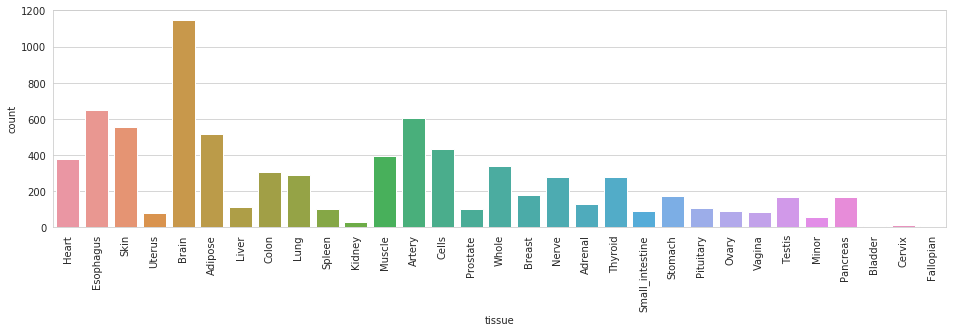

In [70]:
plt.figure(figsize=(16, 4))
f = sns.countplot(data=gtex, x='tissue')
plt.xticks(rotation=90);

In [14]:
datasets = OrderedDict({x: gtex[gtex.tissue == x] for x in 
                        sorted(gtex.tissue.unique())}) 

# Model Training

## 50 Genes, 31 Background Datasets

In [16]:
genes = set(list(np.random.choice(drug_genes, 48, replace=False)) + ['ARAF', 'JAK2'])
fits = fit_genes(genes, datasets)
len(fits)

1550

In [89]:
model, trace = train_linear(n_of_1, genes, datasets, fits)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [sigma, PIK3R6-Whole, PIK3R6-Vagina, PIK3R6-Uterus, PIK3R6-Thyroid, PIK3R6-Testis, PIK3R6-Stomach, PIK3R6-Spleen, PIK3R6-Small_intestine, PIK3R6-Skin, PIK3R6-Prostate, PIK3R6-Pituitary, PIK3R6-Pancreas, PIK3R6-Ovary, PIK3R6-Nerve, PIK3R6-Muscle, PIK3R6-Minor, PIK3R6-Lung, PIK3R6-Liver, PIK3R6-Kidney, PIK3R6-Heart, PIK3R6-Fallopian, PIK3R6-Esophagus, PIK3R6-Colon, PIK3R6-Cervix, PIK3R6-Cells, PIK3R6-Breast, PIK3R6-Brain, PIK3R6-Bladder, PIK3R6-Artery, PIK3R6-Adrenal, PIK3R6-Adipose, IL6R-Whole, IL6R-Vagina, IL6R-Uterus, IL6R-Thyroid, IL6R-Testis, IL6R-Stomach, IL6R-Spleen, IL6R-Small_intestine, IL6R-Skin, IL6R-Prostate, IL6R-Pituitary, IL6R-Pancreas, IL6R-Ovary, IL6R-Nerve, IL6R-Muscle, IL6R-Minor, IL6R-Lung, IL6R-Liver, IL6R-Kidney, IL6R-Heart, IL6R-Fallopian, IL6R-Esophagus, IL6R-Colon, IL6R-Cervix, IL6R-Cells, IL6R-Breast, IL6R-Brai

Sampling 12 chains: 100%|██████████| 14400/14400 [21:09:51<00:00, 59.21s/draws]   
The number of effective samples is smaller than 25% for some parameters.


/home/ubuntu/anaconda3/envs/pan-normal/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


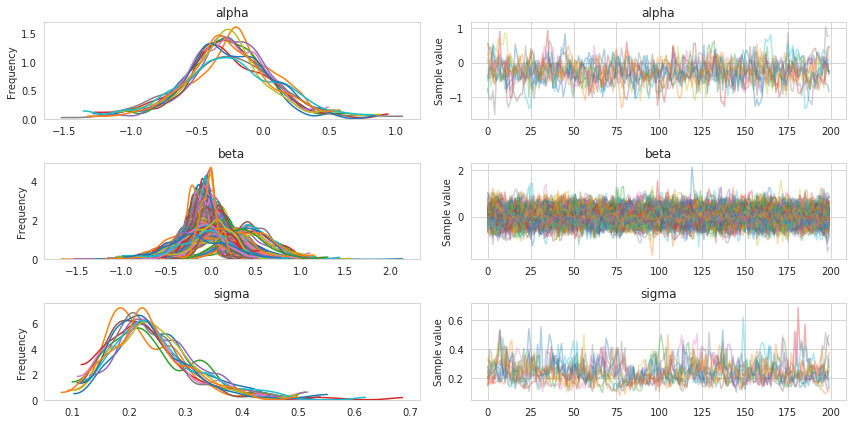

In [91]:
pm.traceplot(trace, varnames=['alpha', 'beta', 'sigma']);

# Parameter Estimates

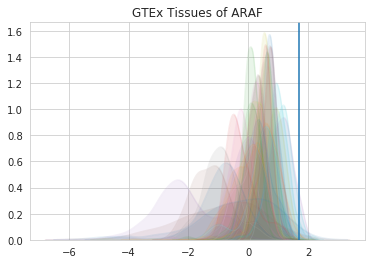

In [129]:
gene = 'ARAF'
tissues = df.tissue.unique()
for t in tissues:
    sns.kdeplot(gtex[gtex.tissue == t][gene], shade=True, alpha=0.1, legend=False)
plt.axvline(n_of_1[gene], label='n_of_1')
plt.title(f'GTEx Tissues of {gene}');

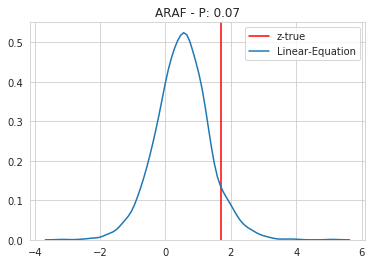

In [95]:
posterior_from_linear(trace, gene)

# Weight by Tissue

In [140]:
tissues = sorted(gtex.tissue.unique())
weight_by_tissue = pd.DataFrame({'Tissues': tissues,
                                 'Weights': [np.median(trace['beta'][:,x]) 
                                             for x in range(len(tissues))]})
weight_by_tissue = weight_by_tissue.sort_values('Weights', ascending=False)
weight_by_tissue.head(5)

,Tissues,Weights
21,Prostate,0.414188
20,Pituitary,0.163094
15,Minor,0.102993
24,Spleen,0.085944
1,Adrenal,0.085810


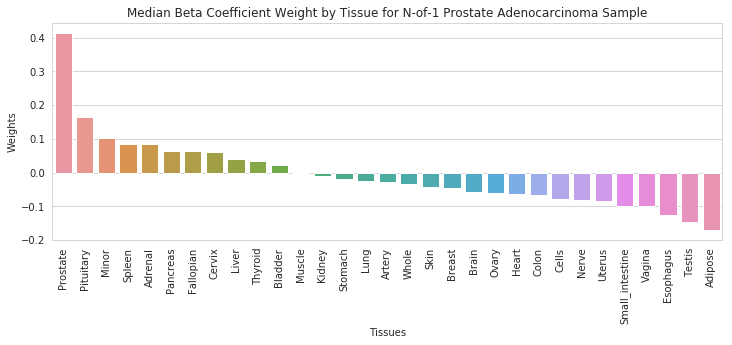

In [128]:
plt.figure(figsize=(12, 4))
sns.barplot(data=weight_by_tissue, x='Tissues', y='Weights')
plt.xticks(rotation=90)
plt.title('Median Beta Coefficient Weight by Tissue for N-of-1 Prostate Adenocarcinoma Sample');

# Comparison to Prostate

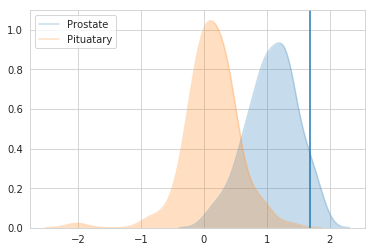

In [21]:
z_pros = gtex[gtex.tissue == 'Prostate']['ARAF']
z_pit = gtex[gtex.tissue == 'Pituitary']['ARAF']
z_true = n_of_1['ARAF']
sns.kdeplot(z_pros, label='Prostate', shade=True, alpha=0.25)
sns.kdeplot(z_pit, label='Pituatary', shade=True, alpha=0.25)
plt.axvline(z_true);

# DownSample

Try 1,000 samples (~84 samples x 12 chains) and compare times / similarity

In [17]:
model, trace = train_linear(n_of_1, genes, datasets, fits, n_samples=83)

Only 83 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sampling 12 chains:  55%|█████▍    | 7102/12996 [9:08:03<8:38:57,  5.28s/draws] 


ValueError: Not enough samples to build a trace.